# This notebook refines the model using only playable songs:

### While generating new songs to play we only want to generate songs with difficulty of 8.  Therefore we will load the refined model and then finetune it only to operate on our desired songs

In [4]:
from pathlib import Path
import pandas as pd
import re

In [5]:
#Get the list of all of the step files
step_files = list(Path("C:/Users/brent/Desktop/StepMania 5").rglob("*.[dD][wW][iI]"))

#Get the list of all of the step files
song_files = list(Path("C:/Users/brent/Desktop/StepMania 5").rglob("*.[mM][pP][3]"))

In [6]:
def process_song(path, title):
    #Open File
    text_file = open(path, "r")
    lines = text_file.readlines()
    text_file.close()
    
    #Combine all text into single line
    song = "".join(lines)
    
    #Remove newline characters
    song = re.sub('\n', '', song)
    
    #Split on semicolon and then add the semicolons back into the respective lines
    song = song.split(';')
    song = [line+';' for line in song][:-1]
    
    #Remove lines that start with 2 // (some files had this for some reason)
    song = [line for line in song if (line.find('//') == -1)]
    
    #Create a dataframe of the song
    df = pd.DataFrame()
    df[title] = song
    return df

def pull_all_step_patterns(song, row):
    song = song[row].str.split(":", n = 3, expand = True)
    song = song[song[0].isin(["#SINGLE","#SOLO"])]
    return song

def remove_leading_zeroes(songs):
    """Take a song step file and remove the leading zeroes"""
    songs[3] = songs[3].str.replace(r"^0+","")
    return songs

def fastaiFormat(songs):
    """Take a list of step files and make it into a format for fastai NLP"""
    songs = songs.reset_index()
    songs = songs[[1,3]]
    songs.columns = ['label','text']

    #Split the song into characters with spaces
    songs['text'] = songs['text'].apply(lambda x: " ".join(x))

    #Remove the trailing semicolon as we can add it back in when we are done predicting songs
    songs['text'] = songs['text'].apply(lambda x: x[:-1])
    
    return songs

def selectedDifficulty(songs, low=1, high=10):
    """Filters the songs only within a specific difficulty range given by low and high (inclusive)"""
    songs = songs[pd.to_numeric(songs[2]).between(low,high)]
    
    return songs


def join_all_step_patterns(step_files):
    """Create a dataframe of all songs for a fastai training model."""
    songs = pd.DataFrame()
    for row, path in enumerate(step_files):
        df = process_song(path, row)
        df = pull_all_step_patterns(df, row)
        songs = pd.concat([songs,df])
    
    songs = remove_leading_zeroes(songs)
    songs = selectedDifficulty(songs, low=8, high=8)
    songs = fastaiFormat(songs)
    
    return songs

In [7]:
songs = join_all_step_patterns(step_files)

In [8]:
songs.head()

,label,text
0,SMANIAC,2 2 ( 8 0 0 2 ) 6 4 8 0 1 0 ( 6 0 0 4 ) 8 2 6 ...
1,SMANIAC,6 0 ( 6 0 0 4 ) 6 8 2 4 6 6 ( 6 0 8 2 8 2 8 0 ...
2,SMANIAC,8 6 2 8 4 0 2 4 2 8 B 0 4 2 0 0 8 6 2 0 7 0 8 ...
3,SMANIAC,8 0 6 0 2 0 4 0 8 0 6 0 2 0 4 0 0 0 A 0 B 0 0 ...
4,MANIAC,1 0 6 0 2 6 4 0 8 0 2 4 6 2 4 0 3 0 4 0 2 4 6 ...


In [9]:
songs.to_csv("songs_8.csv", index=False)

# Refine our Language Model

In [10]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.text import *
import os

In [11]:
from pathlib import Path
import pandas as pd
import re
import string

%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.text import *
import os

cwd = os.getcwd()
path = Path(cwd)

In [12]:
all_letters = list(string.printable + string.whitespace)

#We don't want to remove repetition in the DDR song as that is part of it
customtokenizer = Tokenizer(pre_rules= [], post_rules=[])

processors = [TokenizeProcessor(tokenizer=customtokenizer, mark_fields=False),
            NumericalizeProcessor(vocab=Vocab.create(all_letters, max_vocab=1000, min_freq=0))]

data = (TextList.from_csv(path, "songs_8.csv", cols='text', processor=processors)
                .split_by_rand_pct(0.2)
                .label_for_lm()
                .databunch(bs=96))
data.save('data_block_lm4.pkl')

In [13]:
data_lm = load_data(path, 'data_block_lm4.pkl',bs=96)
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [14]:
learn.load('fine_tuned_3')
learn.load_encoder('fine_tuned_enc_3')

In [15]:
learn.fit_one_cycle(4, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.425844,1.460666,0.481548,00:02
1,1.427103,1.460569,0.482490,00:01
2,1.422698,1.454080,0.481647,00:01
3,1.418551,1.452928,0.483929,00:01


In [16]:
learn.unfreeze()

In [17]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.406029,1.461039,0.485317,00:02
1,1.408560,1.471706,0.478224,00:02
2,1.400575,1.486307,0.473661,00:02
3,1.393351,1.476573,0.479712,00:02
4,1.377061,1.495947,0.482391,00:02
5,1.364157,1.476423,0.483085,00:02
6,1.348438,1.489746,0.484623,00:02
7,1.328786,1.489460,0.487103,00:02
8,1.312450,1.486816,0.485566,00:02
9,1.298570,1.485491,0.483879,00:02


In [18]:
learn.fit_one_cycle(10, 1e-4, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.242651,1.488768,0.485516,00:02
1,1.246537,1.480465,0.487946,00:02
2,1.249150,1.493770,0.484673,00:02
3,1.245571,1.487891,0.484177,00:02
4,1.242252,1.483709,0.487550,00:02
5,1.241086,1.493691,0.484425,00:02
6,1.255058,1.480330,0.488442,00:02
7,1.248351,1.487650,0.486260,00:02
8,1.244021,1.496054,0.483482,00:02
9,1.244210,1.491498,0.487153,00:02


In [19]:
learn.save('fine_tuned_4')
learn.save_encoder('fine_tuned_enc_4')

In [20]:
TEXT = ""
N_WORDS = 200
N_SENTENCES = 1
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.50) for _ in range(N_SENTENCES)))

 8 0 0 0 4 0 0 0 6 0 0 0 8 0 0 0 6 0 0 0 4 0 0 0 2 0 0 0 8 0 0 0 8 0 0 0 2 0 0 0 B 0 0 0 2 0 0 0 8 0 0 0 6 0 0 0 2 0 0 0 8 0 0 0 4 0 0 0 4 0 0 0 6 0 0 0 6 0 0 0 4 0 0 0 6 0 0 0 2 0 0 0 4 0 0 0 4 0 0 0 4 0 0 0 6 0 6 0 6 0 0 0 8 0 6 0 4 0 2 0 4 0 8 0 2 0 0 0 6 0 2 0 8 0 4 0 2 0 6 0 8 0 8 0 6 0 6 0 4 0 2 0 6 0 2 0 8 0 4 0 8 0 6 0 8 0 6 0 4 0 2 0 2 0 8 0 2 0 6 0 2 0 2 0 2 0 8 0 4 0 2 0 4 0 2 0 8 0 6 0


# Now we work on the classifier

In [21]:
from pathlib import Path
import pandas as pd
import re
import string

%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.text import *
import os

cwd = os.getcwd()
path = Path(cwd)

In [22]:
#Try out the datablock API to see if we can replicate and use either no tokenization or our custom tokenizer
all_letters = list(string.printable + string.whitespace)

#We don't want to remove repetition in the DDR song as that is part of it
customtokenizer = Tokenizer(pre_rules= [], post_rules=[])

processors = [TokenizeProcessor(tokenizer=customtokenizer, mark_fields=False),
            NumericalizeProcessor(vocab=Vocab.create(all_letters, max_vocab=1000, min_freq=0))]

data_clas = (TextList.from_csv(path, 'songs_8.csv', cols='text', processor=processors)
                .split_by_rand_pct(0.2)
                .label_from_df('label')
                .databunch(bs=12))
data_clas.save('data_clas_4.pkl')

In [23]:
data_clas = load_data(path, 'data_clas_4.pkl', bs=12)
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3)
learn.load_encoder('fine_tuned_enc_4')

In [24]:
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.080584,1.014374,0.742857,00:24
1,0.926094,0.622466,0.885714,00:24
2,0.784450,0.439262,0.885714,00:24
3,0.657643,0.427970,0.914286,00:24
4,0.582532,0.401975,0.885714,00:24


In [25]:
learn.unfreeze()

In [26]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.371338,0.400832,0.828571,00:28
1,0.398963,0.430115,0.857143,00:27
2,0.401672,0.460057,0.742857,00:28
3,0.387261,0.377784,0.857143,00:27
4,0.379487,0.534043,0.742857,00:28
5,0.368730,0.451201,0.857143,00:27
6,0.333492,0.419125,0.857143,00:27
7,0.321394,0.407617,0.885714,00:27
8,0.306917,0.538058,0.742857,00:27
9,0.289807,0.482225,0.800000,00:27


In [27]:
learn.fit_one_cycle(10, 1e-4, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.218130,0.489474,0.800000,00:27
1,0.232960,0.508499,0.742857,00:27
2,0.228857,0.501192,0.742857,00:27
3,0.221820,0.470494,0.828571,00:27
4,0.232661,0.435988,0.857143,00:28
5,0.232129,0.454233,0.857143,00:27
6,0.229894,0.525846,0.714286,00:27
7,0.217109,0.480825,0.800000,00:27
8,0.219650,0.493729,0.800000,00:27
9,0.216104,0.468333,0.828571,00:27


In [28]:
learn.save('fine_tuned_classifier_4')
learn.save_encoder('fine_tuned_enc_classifier_4')

## What are the most frequently misclassified?

In [29]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data_clas.valid_ds)==len(losses)==len(idxs)

True

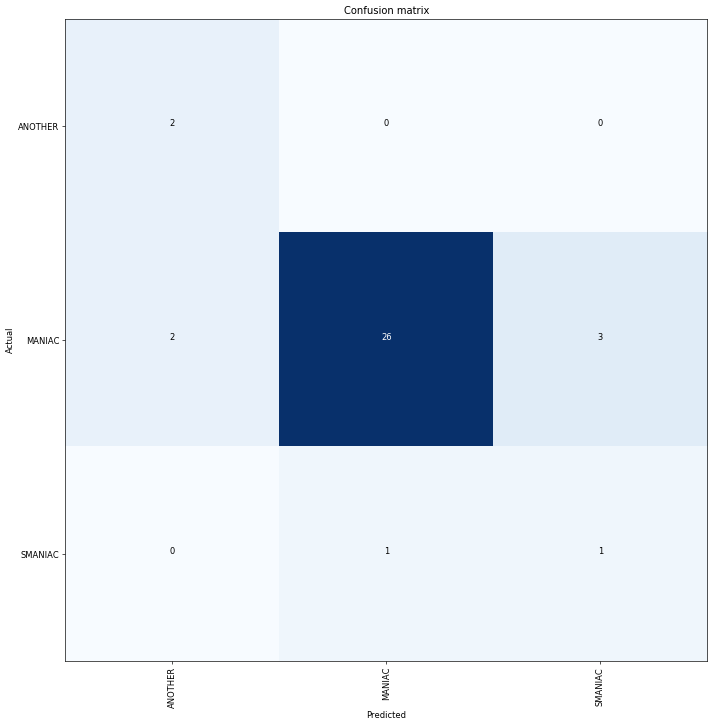

In [30]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [31]:
interp.most_confused(min_val=2)

[('MANIAC', 'SMANIAC', 3), ('MANIAC', 'ANOTHER', 2)]